In [7]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /home/ubuntu
tsnn module path: /home/ubuntu/tsnn


In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional
from tsnn.tstorch import transformers



plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from dataclasses import dataclass
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")


Using device: cuda
GPU name: Tesla T4
Number of GPUs: 1


In [10]:
from typing import Dict

In [11]:
from tsnn.tstorch.models import GlobalMLP, BiDimensionalMLP, OneDimensionalTransformer, CustomBiDimensionalTransformer


In [12]:
# Here let's write out just the necessary code to run one model on one dataset

# Run 1

In [7]:
# Global parameters
T_max = 10000
N1 = 100
F1 = 10
T1 = 10 # This parameter will be the n_rolling

pct_zero_corr = 0.5
low_corr = 0.1
high_corr = 0.1

In [8]:
def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(T_max, N1, F1)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

In [9]:
z = make_gen(split_shift=1)

In [10]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, T1, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [11]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [12]:
z.get_dataloader(n_rolling=T1, roll_y=True)

100%|██████████| 20/20 [05:28<00:00, 16.45s/it]


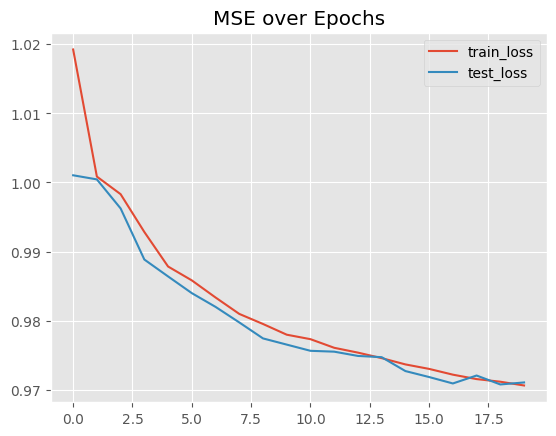

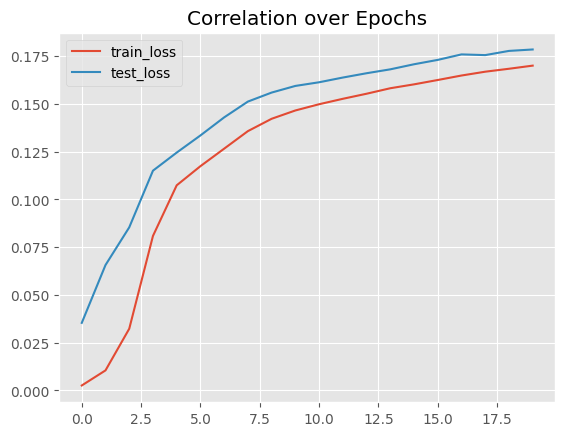

In [13]:
m = CustomBiDimensionalTransformer(N1, F1, T1, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=20, plot=True)


In [14]:

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 

In [15]:
print(out_train, out_test)

display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

0.7836276956465054 0.7829570359772865


,true,optimal,shift
optimal,0.217,nan,nan
shift,0.217,1.000,nan
model_torch,0.174,0.784,0.784


,true,optimal,shift
optimal,0.220,nan,nan
shift,0.220,1.000,nan
model_torch,0.172,0.785,0.785


# Run 2

In [7]:
# Global parameters
T_max = 10000
N1 = 100
F1 = 10
T1 = 10 # This parameter will be the n_rolling

pct_zero_corr = 0.5
low_corr = 0.01
high_corr = 0.01

In [8]:
def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(T_max, N1, F1)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

In [9]:
z = make_gen(split_shift=1)

In [10]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, T1, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [11]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [12]:
z.get_dataloader(n_rolling=T1, roll_y=True)

100%|██████████| 20/20 [05:28<00:00, 16.41s/it]


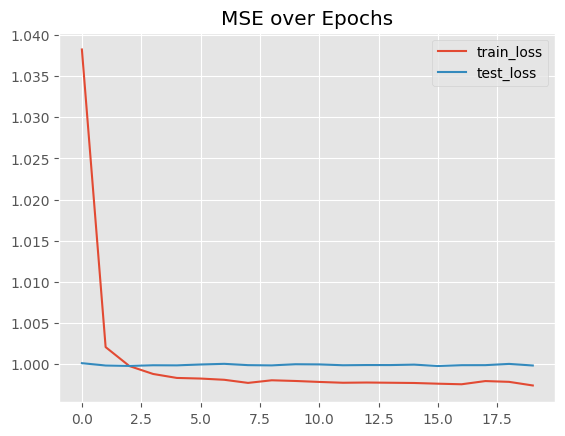

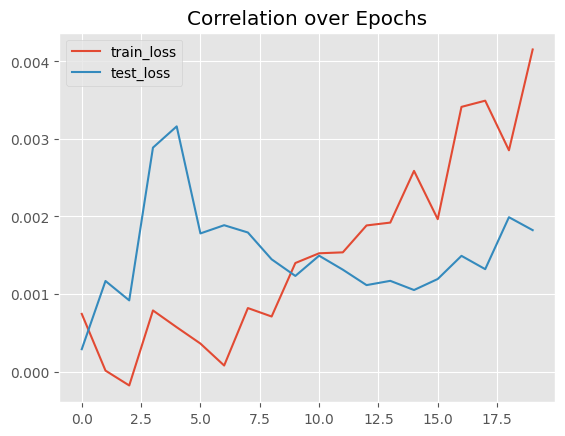

In [13]:
m = CustomBiDimensionalTransformer(N1, F1, T1, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=20, plot=True)


In [14]:

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 

In [15]:
print(out_train, out_test)

display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

0.03583278691693166 0.036940902432832184


,true,optimal,shift
optimal,0.023,nan,nan
shift,0.023,1.000,nan
model_torch,0.010,0.036,0.036


,true,optimal,shift
optimal,0.020,nan,nan
shift,0.020,1.000,nan
model_torch,0.002,0.036,0.036


# Run 3

In [7]:
# Global parameters
T_max = 10000
N1 = 500
F1 = 10
T1 = 10 # This parameter will be the n_rolling

pct_zero_corr = 0.5
low_corr = 0.1
high_corr = 0.1

In [8]:
def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(T_max, N1, F1)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

In [9]:
z = make_gen(split_shift=1)

In [10]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, T1, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [11]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [12]:
z.get_dataloader(n_rolling=T1, roll_y=True, batch_size=16)

100%|██████████| 2/2 [06:55<00:00, 207.78s/it]


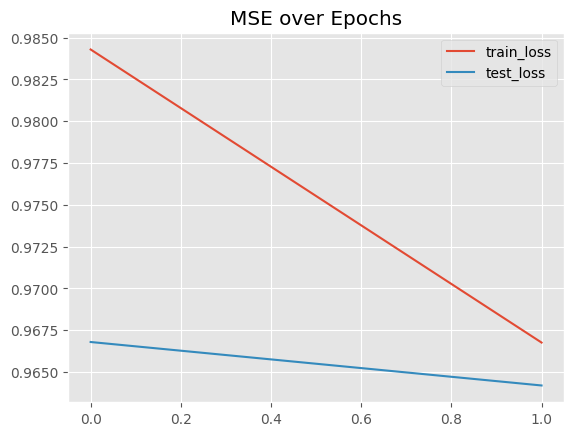

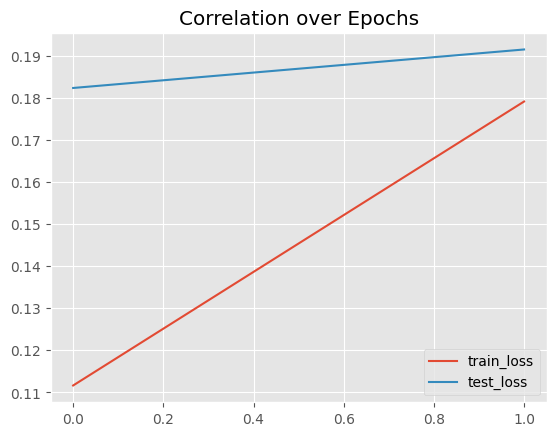

In [13]:
m = CustomBiDimensionalTransformer(N1, F1, T1, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=2, plot=True)


In [ ]:

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 

In [ ]:
print(out_train, out_test)

display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

0.7836276956465054 0.7829570359772865


,true,optimal,shift
optimal,0.217,nan,nan
shift,0.217,1.000,nan
model_torch,0.174,0.784,0.784


,true,optimal,shift
optimal,0.220,nan,nan
shift,0.220,1.000,nan
model_torch,0.172,0.785,0.785


# Run 4

In [13]:
# Global parameters
T_max = 10000
N1 = 50
F1 = 10
T1 = 10 # This parameter will be the n_rolling

pct_zero_corr = 0.5
low_corr = 0.1
high_corr = 0.1

In [14]:
def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(T_max, N1, F1)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

In [15]:
z = make_gen(split_shift=1)

In [16]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, T1, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [17]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [18]:
z.get_dataloader(n_rolling=T1, roll_y=True, batch_size=16)

100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


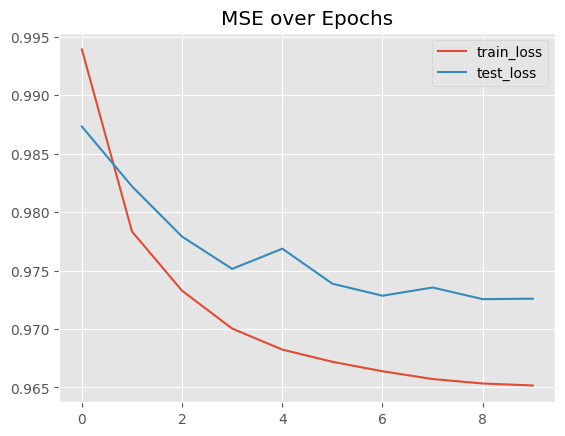

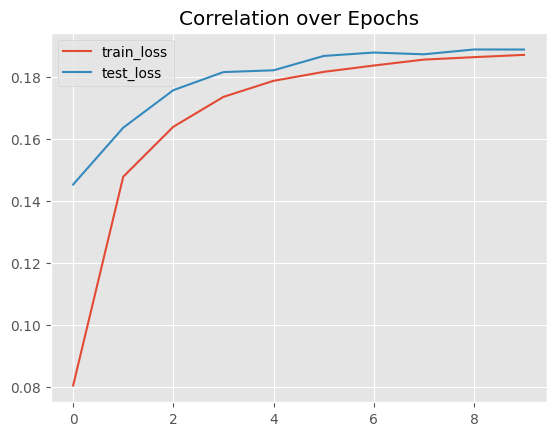

In [19]:
m = CustomBiDimensionalTransformer(N1, F1, T1, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=10, plot=True)


In [20]:

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 

In [21]:
print(out_train, out_test)

display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

0.8464170798017372 0.8455007758794524


,true,optimal,shift
optimal,0.218,nan,nan
shift,0.218,1.000,nan
model_torch,0.195,0.847,0.847


,true,optimal,shift
optimal,0.217,nan,nan
shift,0.217,1.000,nan
model_torch,0.184,0.845,0.845


## With lower floating precision

In [51]:
#torch.cuda.amp.autocast('cuda')

In [42]:
# Global parameters
T_max = 10000
N1 = 50
F1 = 10
T1 = 10 # This parameter will be the n_rolling

pct_zero_corr = 0.5
low_corr = 0.1
high_corr = 0.1

In [43]:
def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(T_max, N1, F1)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

In [44]:
z = make_gen(split_shift=1)

In [45]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, T1, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [46]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [47]:
z.get_dataloader(n_rolling=T1, roll_y=True, batch_size=16)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


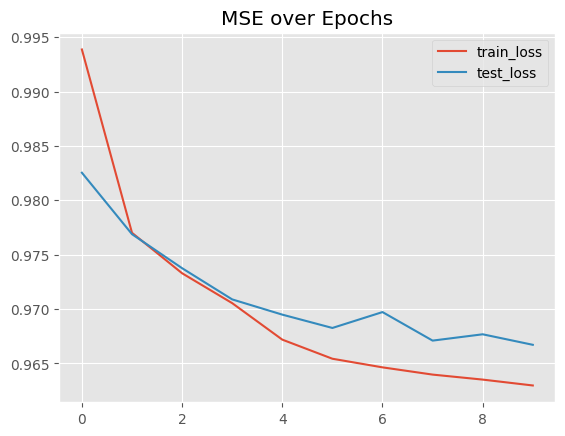

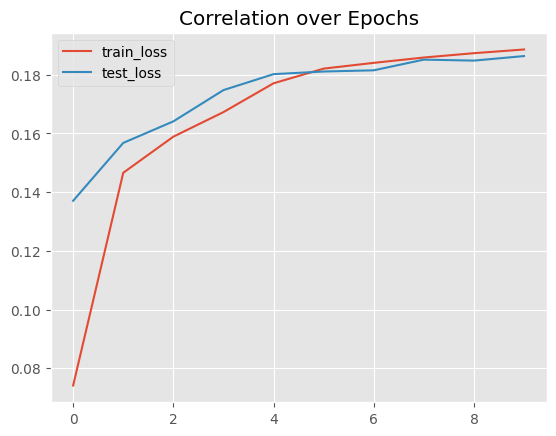

In [48]:
m = CustomBiDimensionalTransformer(N1, F1, T1, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=10, plot=True)


In [49]:

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 

In [50]:
print(out_train, out_test)

display(comp.correl(z, mode='train'))
display(comp.correl(z, mode='test'))

0.8543754625583324 0.8534908571503403


,true,optimal,shift
optimal,0.220,nan,nan
shift,0.220,1.000,nan
model_torch,0.199,0.854,0.854


,true,optimal,shift
optimal,0.214,nan,nan
shift,0.214,1.000,nan
model_torch,0.185,0.852,0.852
